In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 6.5 MB/s eta 0:00:00


In [ ]:
! pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218921 sha256=a18de518a425ca18fe5172d15e0077ba06e1b1a8c0f81fe7622e64a45bb3164c
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
!pip install newsapi-python


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install yahoo_fin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 13.2 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1270 sha256=c86bad08b608aaccccd903ddede28669678fc208aa620d13793a0ee841c706fa
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24589 sha256=7e504b95663377fa81087b88451cc37464af176071817fcbc1f698ac3e2a2ee9
  Stored in directory: /root/.cache/pip/wheels/70/4b/f0/ea

In [ ]:
pip install requests lxml


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install fundamental_analysis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement fundamental_analysis (from versions: none)
ERROR: No matching distribution found for fundamental_analysis


In [ ]:
pip install --upgrade yfinance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import yfinance as yf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import pandas_ta as pta
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from google.colab import files
import pytz
from dateutil.parser import parse
from yahoo_fin import stock_info as si
import requests
from lxml import html



from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer



def fetch_yahoo_finance_comments(ticker, date):
    url = f"https://finance.yahoo.com/quote/{ticker}/community?p={ticker}&.tsrc=fin-srch&conversation_start={date}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    comments = [comment.text.strip() for comment in soup.find_all('div', class_='C($c-fuji-grey-l) Mb(2px) Fz(14px) Lh(20px) Pend(8px)')]
    return comments


def fetch_stock_prices(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    hist = stock.history(start=start_date, end=end_date)
    # hist = hist.drop(['Dividends', 'Stock Splits'], axis=1)
    hist.index.name = 'Date'
    hist.reset_index(inplace=True)
    return hist


def get_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']

def fetch_daily_news(date, query):
    formatted_date = date.strftime("%Y-%m-%d")
    formatted_query = '+'.join(query.split())
    url = f"https://www.reuters.com/search/news?sortBy=relevance&dateRange=all&blob={formatted_query}+{formatted_date}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    headlines = [headline.text.strip() for headline in soup.find_all('h3', class_='search-result-title')]
    return headlines

def calculate_daily_sentiment(hist, query):
    daily_sentiment_scores = []

    for date in hist['Date']:
        news_headlines = fetch_daily_news(date, query)
        sentiment_score = calculate_average_sentiment(news_headlines) if news_headlines else 0
        daily_sentiment_scores.append(sentiment_score)

    return daily_sentiment_scores

def calculate_average_sentiment(headlines):
    sentiment_scores = [get_sentiment(headline) for headline in headlines]
    return sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0

def fetch_company_name(ticker):
    stock = yf.Ticker(ticker)
    return stock.info.get("shortName", "").replace(" ", "+")


def fetch_financial_data_fmp(ticker, hist, api_key):
    base_url = "https://financialmodelingprep.com/api/v3"
    income_statement_url = f"{base_url}/income-statement/{ticker}?apikey={api_key}"
    balance_sheet_url = f"{base_url}/balance-sheet-statement/{ticker}?apikey={api_key}"
    quote_url = f"{base_url}/quote/{ticker}?apikey={api_key}"

    income_statement_response = requests.get(income_statement_url).json()
    balance_sheet_response = requests.get(balance_sheet_url).json()
    quote_response = requests.get(quote_url).json()

    latest_income_statement = income_statement_response[0]
    latest_balance_sheet = balance_sheet_response[0]

    shares_outstanding = quote_response[0]['sharesOutstanding']
    total_assets = pd.Series(latest_balance_sheet['totalAssets'], index=hist.index)
    net_income = pd.Series(latest_income_statement['netIncome'], index=hist.index)
    total_revenue = pd.Series(latest_income_statement['revenue'], index=hist.index)

    return shares_outstanding, total_assets, net_income, total_revenue




def create_dataset(start_date, end_date, ticker):

    hist = fetch_stock_prices(ticker, start_date, end_date)
    daily_sentiment_scores_sp500 = calculate_daily_sentiment(hist, "S%26P+500")
    hist['SentimentScoreSP500'] = daily_sentiment_scores_sp500
    
    daily_sentiment_scores_stock_market = calculate_daily_sentiment(hist, "stock+market")
    hist['SentimentScoreStockMarket'] = daily_sentiment_scores_stock_market
    
    company_name = fetch_company_name(ticker)
    daily_sentiment_scores_ticker = calculate_daily_sentiment(hist, company_name)
    hist['SentimentScoreTicker'] = daily_sentiment_scores_ticker

    # Fetch Yahoo Finance comments and calculate sentiment scores
    yahoo_finance_comments = fetch_yahoo_finance_comments(ticker)
    yahoo_finance_sentiment_scores = [get_sentiment(comment) for comment in yahoo_finance_comments]

    # Calculate the average sentiment score for Yahoo Finance comments
    # Calculate the average sentiment score for Yahoo Finance comments
    if len(yahoo_finance_sentiment_scores) > 0:
        avg_yahoo_finance_sentiment_score = sum(yahoo_finance_sentiment_scores) / len(yahoo_finance_sentiment_scores)
    else:
        avg_yahoo_finance_sentiment_score = 0

    # Add the average sentiment score for Yahoo Finance comments to the dataset
    hist['AvgYahooFinanceSentimentScore'] = avg_yahoo_finance_sentiment_score





    
    hist['Date'] = pd.to_datetime(hist['Date'])
    hist.set_index('Date', inplace=True)
    hist['Year'] = hist.index.year
    hist['Week'] = hist.index.isocalendar().week
    hist['return_t'] = hist['Close'].pct_change()
    hist['return_t_plus_1'] = hist['Close'].pct_change().shift(-1)

    # Calculate ATR
    high = hist['High']
    low = hist['Low']
    close = hist['Close']
    previous_close = hist['Close'].shift(1)
    volume = hist['Volume']
    true_range = pd.DataFrame(columns=['TR'])
    true_range['TR'] = high - low
    true_range['TR'] = pd.concat([abs(high - previous_close), abs(low - previous_close), true_range['TR']], axis=1).max(axis=1)
    atr = true_range['TR'].rolling(window=14).mean()
    hist['atr'] = atr

    # Calculate ADX
    dm_pos = high.diff()
    dm_neg = low.diff().abs()
    dm_pos[dm_pos < 0] = 0
    dm_neg[dm_neg < 0] = 0
    tr = pd.concat([high - low, (high - previous_close).abs(), (low - previous_close).abs()], axis=1).max(axis=1)
    dm_pos_smoothed = dm_pos.rolling(window=14).mean()
    dm_neg_smoothed = dm_neg.rolling(window=14).mean()
    tr_smoothed = tr.rolling(window=14).mean()
    di_pos = dm_pos_smoothed / tr_smoothed * 100
    di_neg = dm_neg_smoothed / tr_smoothed * 100
    dx = ((di_pos - di_neg).abs() / (di_pos + di_neg) * 100).rolling(window=14).mean()
    adx = dx.rolling(window=14).mean()
    hist['adx'] = adx

    # Calculate TRIX
    ema1 = close.ewm(span=12, adjust=False).mean()
    ema2 = ema1.ewm(span=12, adjust=False).mean()
    ema3 = ema2.ewm(span=12, adjust=False).mean()
    trix = ((ema3 - ema3.shift(1)) / ema3.shift(1) * 100).rolling(window=14).mean()
    hist['trix'] = trix

    # Calculate ADXR
    adxr = ((adx + adx.shift(14)) / 2).rolling(window=14).mean()
    hist['adxr'] = adxr

    # Calculate CCI
    tp = (high + low + close) / 3
    tp_sma = tp.rolling(window=14).mean()
    tp_std = tp.rolling(window=14).std()
    cci = (tp - tp_sma) / (0.015 * tp_std)
    hist['cci'] = cci

    # Calculate MACD
    ema12 = close.ewm(span=12, adjust=False).mean()
    ema26 = close.ewm(span=26, adjust=False).mean()
    macd = ema12 - ema26
    signal = macd.ewm(span=9, adjust=False).mean()
    hist['macd'] = macd
    hist['macdsignal'] = signal
    hist['macdh'] = macd - signal

    # Calculate RSI
    delta = close.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss.abs()
    rsi = 100 - (100 / (1 + rs))
    hist['rsi_14'] = rsi

    # Calculate Stochastic Oscillator
    low_min = low.rolling(window=14).min()
    high_max = high.rolling(window=14).max()
    k_percent = 100 * (close - low_min) / (high_max - low_min)
    d_percent = k_percent.rolling(window=3).mean()
    hist['kdjk'] = k_percent
    hist['kdjd'] = d_percent

    # Calculate Williams %R
    wr_percent = -100 * (high_max - close) / (high_max - low_min)
    hist['wr_14'] = wr_percent

    # Calculate Average True Range

    true_range = pd.DataFrame(columns=['TR'])
    true_range['TR'] = high - low
    true_range['TR'] = np.maximum(np.maximum(high - low, abs(high - close.shift())), abs(low - close.shift()))
    atr = true_range['TR'].rolling(window=14).mean()

    hist['atr'] = atr
    hist['atr_percent'] = atr.pct_change()

    # Calculate Chaikin Money Flow
    ad = ((2 * close - low - high) / (high - low)) * volume
    cmf = ad.rolling(window=20).sum() / volume.rolling(window=20).sum()
    hist['cmf'] = cmf

    # Calculate Moving Averages
    hist['ma_10'] = close.rolling(window=10).mean()
    hist['ma_30'] = close.rolling(window=30).mean()
    hist['ma_50'] = close.rolling(window=50).mean()
    hist['ma_200'] = close.rolling(window=200).mean()

    # Calculate MACD
    exp1 = close.ewm(span=12, adjust=False).mean()
    exp2 = close.ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    hist['macd'] = macd
    hist['macdsignal'] = signal
    hist['macdh'] = macd - signal

    # Calculate Commodity Channel Index
    tp = (high + low + close) / 3
    cci = (tp - tp.rolling(window=14).mean()) / (0.015 * tp.rolling(window=14).std())
    hist['cci'] = cci

    # Calculate Average Directional Index (ADX) and ADX Rating (ADXR)
    adx_values = pta.adx(high, low, close)['ADX_14']
    adx_moving_average = adx_values.rolling(window=14).mean()
    adxr = (adx_moving_average.shift() + adx_moving_average) / 2
    hist['adx'] = adx_values
    hist['adxr'] = adxr

    # Calculate Triple Exponential Moving Average (TRIX)
    # Calculate Triple Exponential Moving Average (TRIX)
    trix = close.ewm(span=15, adjust=False).mean().ewm(span=15, adjust=False).mean().ewm(span=15, adjust=False).mean()
    hist['trix'] = (trix - trix.shift(1)) / trix.shift(1)

    # Calculate Average Directional Index (ADX)
    high, low, close = hist['High'], hist['Low'], hist['Close']
    plus_dm = high - high.shift(1)
    minus_dm = low.shift(1) - low
    plus_dm = plus_dm.where((plus_dm > minus_dm) & (plus_dm > 0), 0)
    minus_dm = minus_dm.where((minus_dm > plus_dm) & (minus_dm > 0), 0)
    true_range = pd.DataFrame(columns=['TR'])
    true_range['TR'] = high - low
    true_range['TR'] = true_range['TR'].combine(abs(high - close.shift()), func=max)
    true_range['TR'] = true_range['TR'].combine(abs(low - close.shift()), func=max)
    atr = true_range['TR'].rolling(window=14).mean()
    plus_di = 100 * plus_dm.rolling(window=14).sum() / atr
    minus_di = 100 * minus_dm.rolling(window=14).sum() / atr
    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    adx = dx.rolling(window=14).mean()
    hist['adx'] = adx

    # Calculate Average Directional Movement Index Rating (ADXR)
    adxr = adx.rolling(window=14).mean()
    hist['adxr'] = adxr

    # Calculate Commodity Channel Index (CCI)
    tp = (high + low + close) / 3
    cci = (tp - tp.rolling(window=14).mean()) / (0.015 * tp.rolling(window=14).apply(lambda x: np.std(x)))
    hist['cci'] = cci

    # Calculate Moving Average Convergence Divergence (MACD)
    ema_12 = close.ewm(span=12, adjust=False).mean()
    ema_26 = close.ewm(span=26, adjust=False).mean()
    macd = ema_12 - ema_26
    macd_signal = macd.ewm(span=9, adjust=False).mean()
    macd_hist = macd - macd_signal
    hist['macd'] = macd
    hist['macd_signal'] = macd_signal
    hist['macd_hist'] = macd_hist

    # Calculate Relative Strength Index (RSI)
    delta = close.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean().abs()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    hist['rsi_14'] = rsi

    # Calculate Stochastic Oscillator
    low_14 = low.rolling(window=14).min()
    high_14 = high.rolling(window=14).max()
    stoch = 100 * (close - low_14) / (high_14 - low_14)
    kdjk = stoch.rolling(window=3).mean()
    kdjd = kdjk.rolling(window=3).mean()
    hist['kdjk'] = kdjk
    hist['kdjd'] = kdjd

    # Calculate Williams %R
    low_14 = low.rolling(window=14).min()
    high_14 = high.rolling(window=14).max()
    wr = -100 * (high_14 - close) / (high_14 - low_14)
    hist['wr_14'] = wr

    # Calculate Average True Range (ATR)
    true_range = pd.DataFrame(columns=['TR'])
    true_range['TR'] = high - low
    true_range['TR'] = true_range['TR'].combine(abs(high - previous_close), func=max)
    true_range['TR'] = true_range['TR'].combine(abs(low - previous_close), func=max)
    atr = true_range['TR'].rolling(window=14).mean()
    hist['atr'] = atr

    # Calculate Chaikin Money Flow (CMF)
    mf_multiplier = ((close - low) - (high - close)) / (high - low)
    mf_volume = mf_multiplier * volume
    cmf = mf_volume.rolling(window=20).sum() / volume.rolling(window=20).sum()
    hist['cmf'] = cmf

    ticker = "AAPL"
    api_key = "1e2775fa39710808dfc156e18eb4cd2a"

    shares_outstanding, total_assets, net_income, total_revenue = fetch_financial_data_fmp(ticker, hist, api_key)

    hist['MarketCap'] = hist['Close'] * shares_outstanding
    hist['PbRatio'] = hist['MarketCap'] / total_assets.iloc[-1]
    hist['PeRatio'] = hist['MarketCap'] / net_income.iloc[-1]
    hist['PsRatio'] = hist['MarketCap'] / total_revenue.iloc[-1]
    

    return hist

# def scale_data(df, columns_to_exclude):
#     scaler = MinMaxScaler()
#     for col in df.columns:
#         if col not in columns_to_exclude:
#             df[col] = scaler.fit_transform(df[[col]])
#     return df


def process_and_save_data_for_years(ticker, start_year, end_year):

    file_name_daily = f"{ticker}_daily_processed_data.csv"
    sentiment_columns = ['SentimentScoreSP500', 'SentimentScoreStockMarket', 'SentimentScoreTicker']

    all_years_daily = []


    for year in range(start_year, end_year + 1):
        print(f"Processing data for the year {year}...")
        start_date = datetime(year, 1, 1)
        end_date = datetime(year, 3, 31)

        hist = create_dataset(start_date, end_date, ticker)
        # hist = scale_data(hist, sentiment_columns)
        all_years_daily.append(hist)

        print(f"Year {year} processing complete")

    # Concatenate all years' data
    daily_data = pd.concat(all_years_daily, ignore_index=True)

    # Save daily data to CSV file
    daily_data.to_csv(file_name_daily, index=False)

    print("Data processing and saving complete")



def download_csv(file_name):
    try:
        files.download(file_name)
        print(f"{file_name} downloaded successfully.")
    except Exception as e:
        print(f"An error occurred while downloading {file_name}: {e}")

# Call the process_and_save_data_for_years function


ticker = "AAPL"
start_year = 2020
end_year = 2020
process_and_save_data_for_years(ticker, start_year, end_year)

# Download the generated daily and weekly CSV files
file_name_daily = f"{ticker}_daily_processed_data.csv"

download_csv(file_name_daily)



Processing data for the year 2020...
Year 2020 processing complete
Data processing and saving complete


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AAPL_daily_processed_data.csv downloaded successfully.


In [ ]:
hist = pd.read_csv('/content/AAPL_daily_processed_data.csv')


In [ ]:
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SentimentScoreSP500,SentimentScoreStockMarket,SentimentScoreTicker,...,ma_10,ma_30,ma_50,ma_200,macd_signal,macd_hist,MarketCap,PbRatio,PeRatio,PsRatio
0,72.444314,73.510538,72.187543,73.449402,135480400,0.0,0.0,0.07320,-0.09117,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,1.162109e+12,3.294380,11.644029,2.947062
1,72.666833,73.505624,72.507880,72.735306,146322800,0.0,0.0,0.02732,-0.12204,0.000000,...,NaN,NaN,NaN,NaN,-0.011393,-0.045572,1.150811e+12,3.262351,11.530823,2.918410
2,71.845164,73.354009,71.590834,73.314880,118387200,0.0,0.0,0.07320,0.20396,-0.015310,...,NaN,NaN,NaN,NaN,-0.020057,-0.034656,1.159981e+12,3.288347,11.622704,2.941665
3,73.324680,73.583898,72.747555,72.970093,108872000,0.0,0.0,0.02732,-0.12081,-0.092460,...,NaN,NaN,NaN,NaN,-0.032011,-0.047817,1.154525e+12,3.272882,11.568044,2.927830
4,72.669293,74.449588,72.669293,74.143906,132079200,0.0,0.0,0.07320,0.02960,0.062820,...,NaN,NaN,NaN,NaN,-0.026601,0.021641,1.173097e+12,3.325530,11.754130,2.974928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,57.938069,60.715352,57.433110,60.516800,287531200,0.0,0.0,-0.03612,-0.08924,-0.156225,...,61.003131,69.545293,72.776657,NaN,-3.701317,-0.726289,9.574907e+11,2.714322,9.593807,2.428158
57,61.465440,63.303887,59.884375,60.183430,303602000,0.0,0.0,0.00000,-0.10993,-0.140500,...,60.269958,68.939913,72.430099,NaN,-3.808949,-0.430530,9.522162e+11,2.699370,9.540958,2.414782
58,60.428558,63.409292,60.389337,63.350464,252087200,0.0,0.0,0.02732,-0.10193,-0.156225,...,60.520233,68.378084,72.167816,NaN,-3.805386,0.014254,1.002325e+12,2.841419,10.043032,2.541855
59,61.955689,62.720483,60.558470,60.727608,204216800,0.0,0.0,0.00000,0.05748,0.000000,...,59.779216,67.747864,71.859629,NaN,-3.765487,0.159597,9.608261e+11,2.723777,9.627227,2.436617


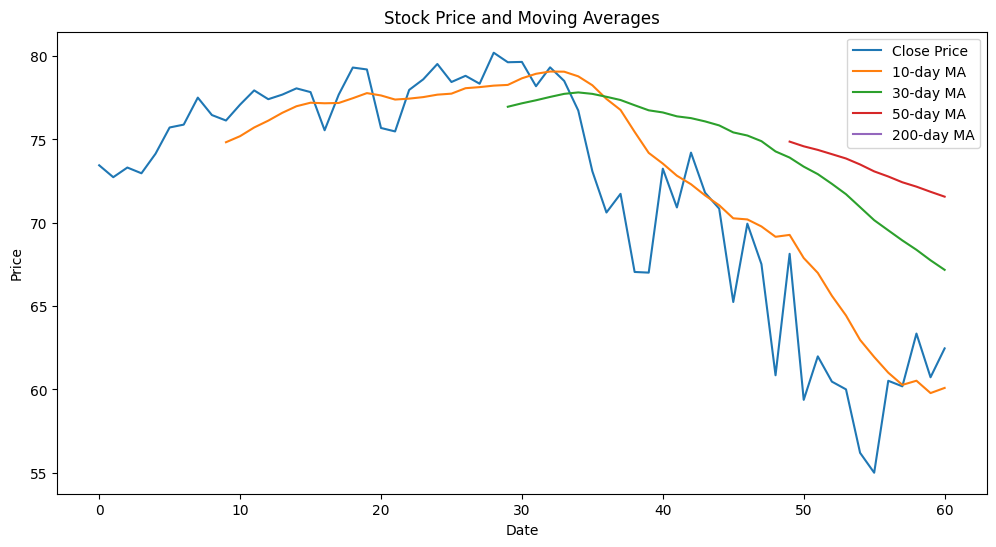

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(hist.index, hist['Close'], label='Close Price')
plt.plot(hist.index, hist['ma_10'], label='10-day MA')
plt.plot(hist.index, hist['ma_30'], label='30-day MA')
plt.plot(hist.index, hist['ma_50'], label='50-day MA')
plt.plot(hist.index, hist['ma_200'], label='200-day MA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price and Moving Averages')
plt.legend()
plt.show()


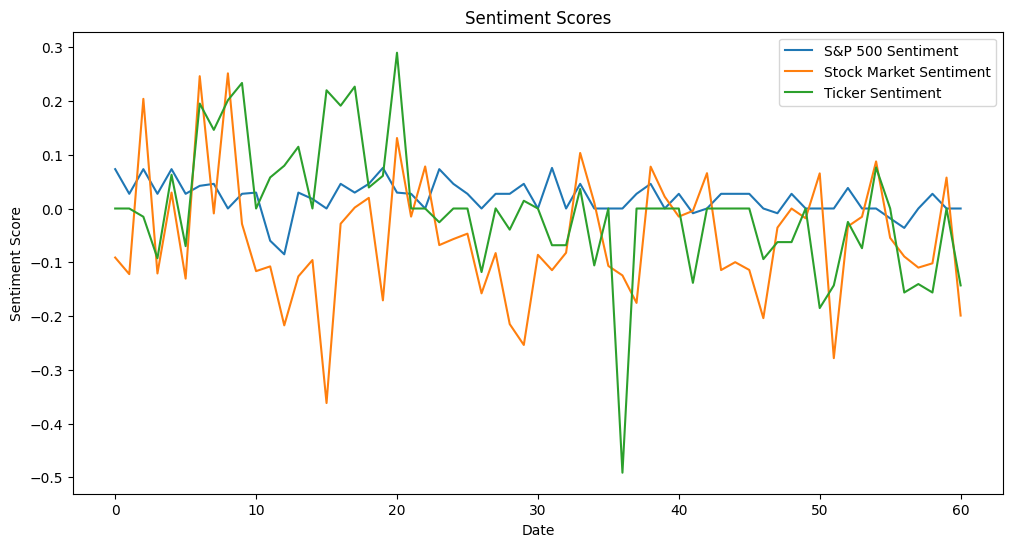

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(hist.index, hist['SentimentScoreSP500'], label='S&P 500 Sentiment')
plt.plot(hist.index, hist['SentimentScoreStockMarket'], label='Stock Market Sentiment')
plt.plot(hist.index, hist['SentimentScoreTicker'], label='Ticker Sentiment')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores')
plt.legend()
plt.show()


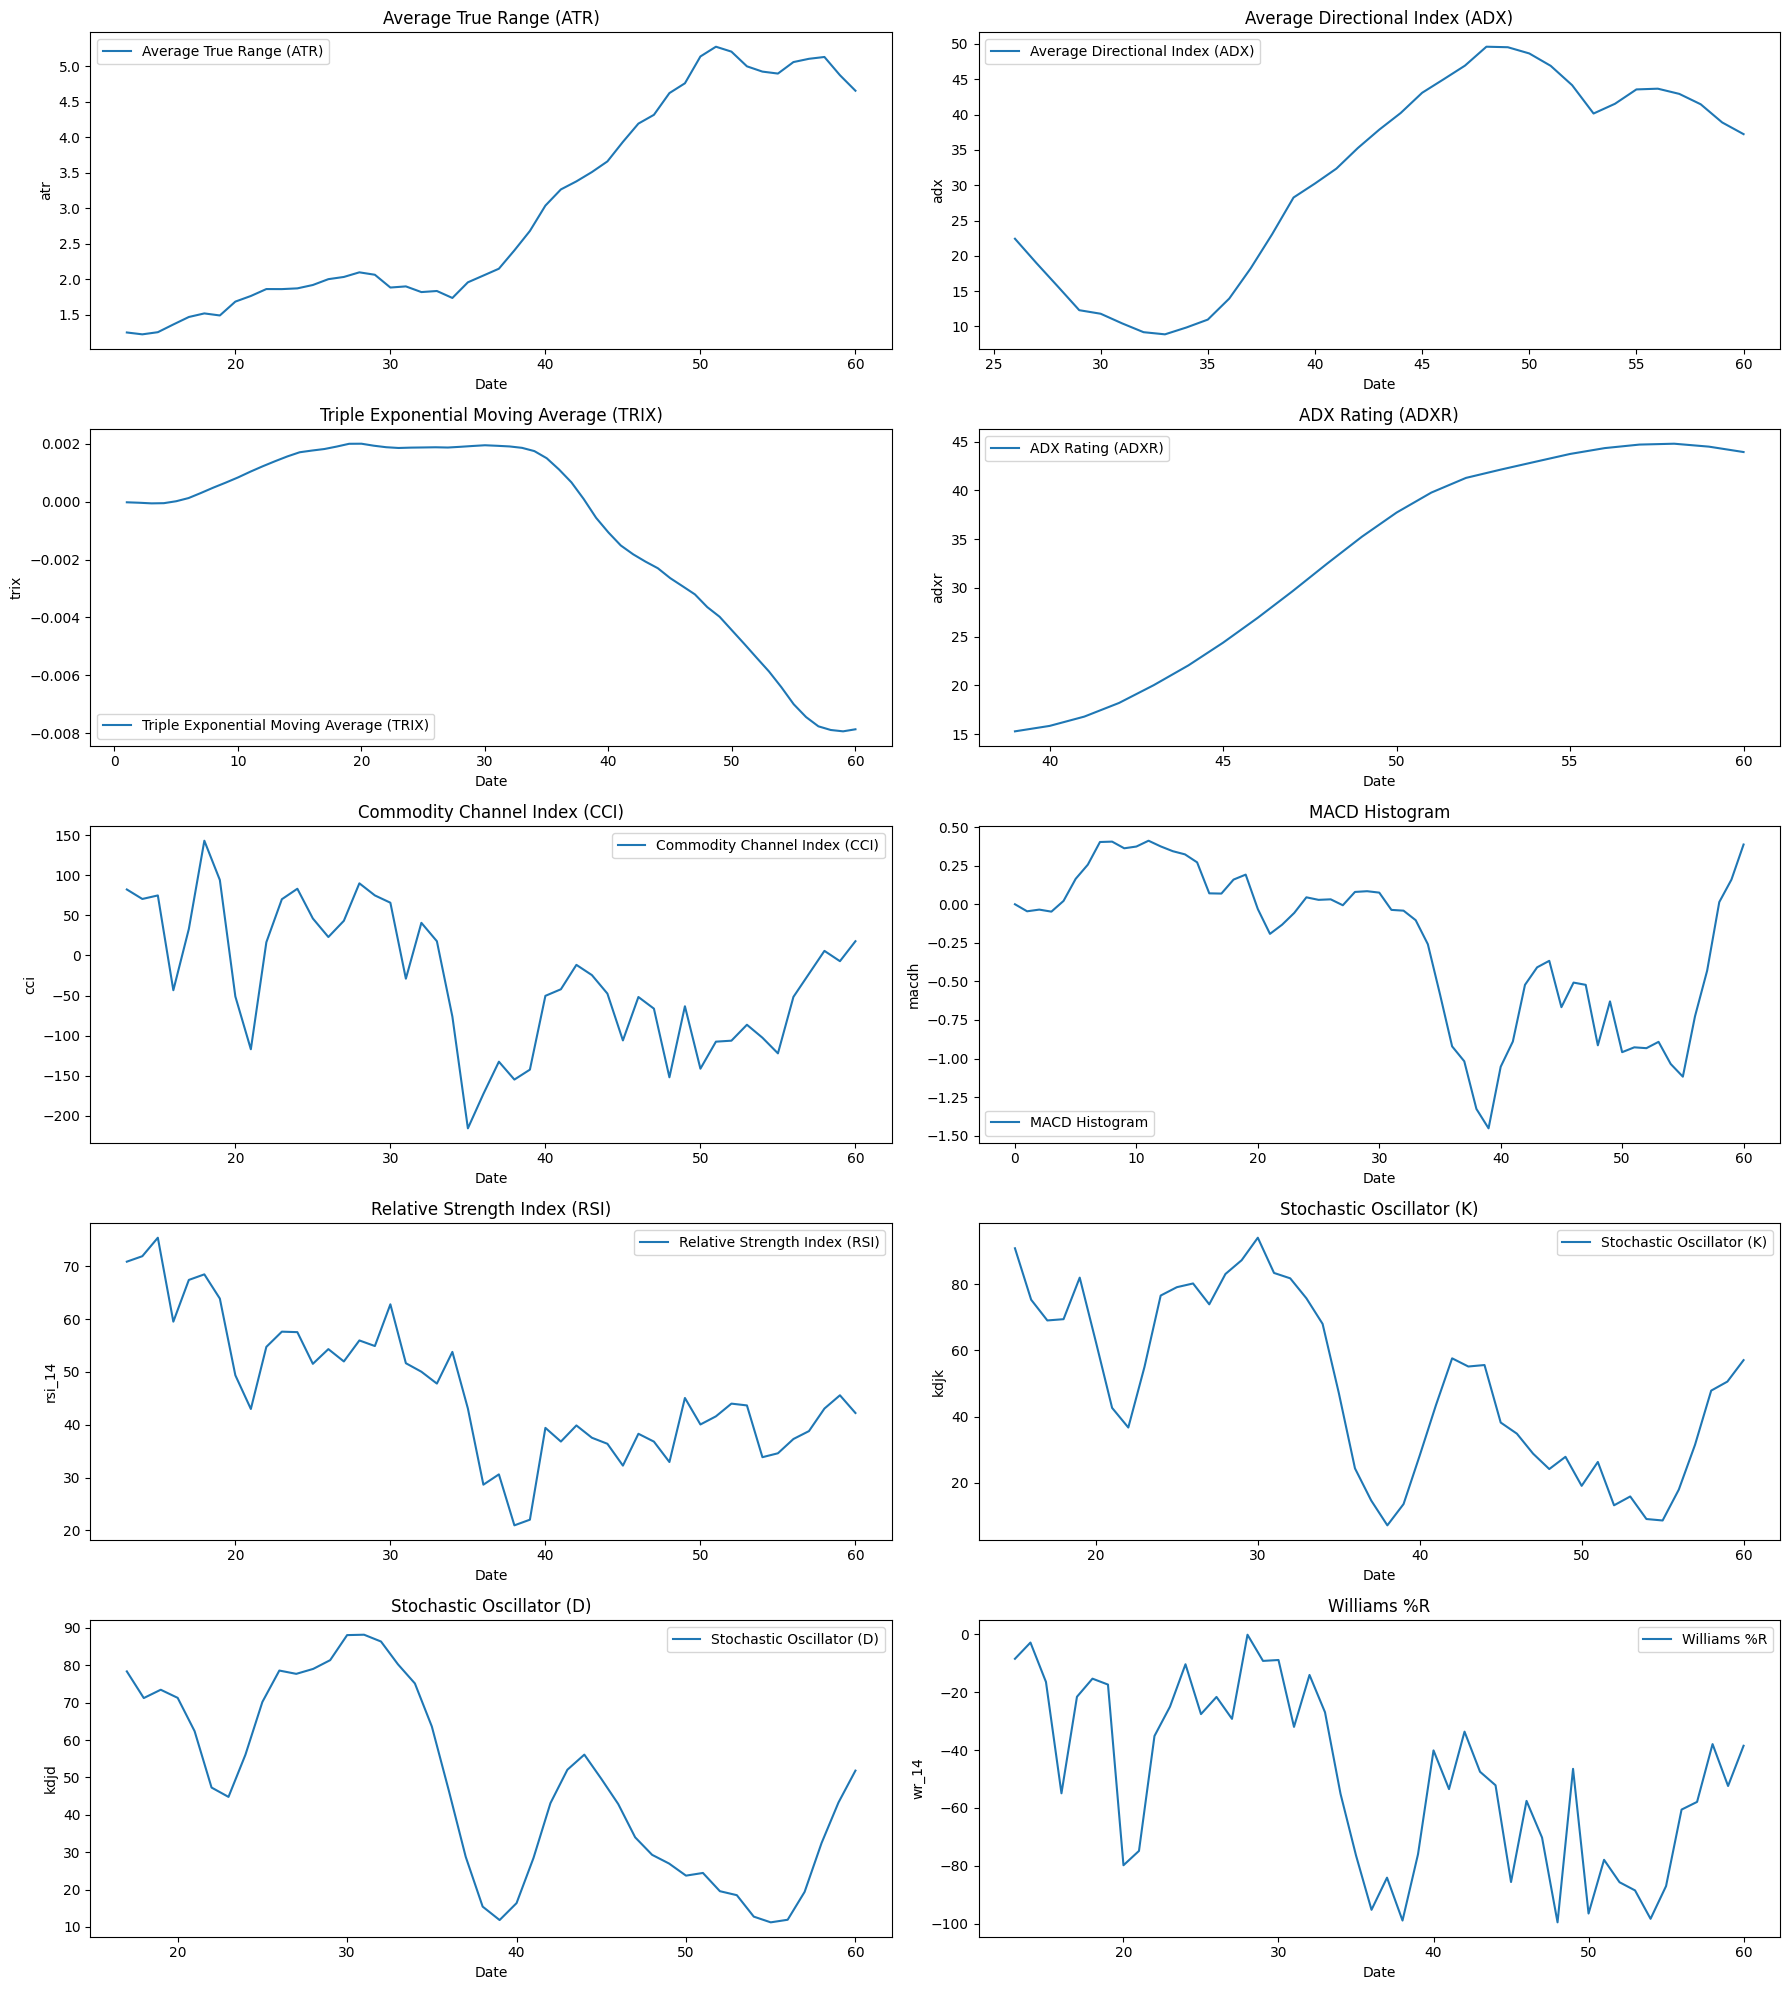

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 20))
axes = axes.flatten()

indicators = [
    ('atr', 'Average True Range (ATR)'),
    ('adx', 'Average Directional Index (ADX)'),
    ('trix', 'Triple Exponential Moving Average (TRIX)'),
    ('adxr', 'ADX Rating (ADXR)'),
    ('cci', 'Commodity Channel Index (CCI)'),
    ('macdh', 'MACD Histogram'),
    ('rsi_14', 'Relative Strength Index (RSI)'),
    ('kdjk', 'Stochastic Oscillator (K)'),
    ('kdjd', 'Stochastic Oscillator (D)'),
    ('wr_14', "Williams %R"),
]

for i, (indicator, title) in enumerate(indicators):
    ax = axes[i]
    ax.plot(hist.index, hist[indicator], label=title)
    ax.set_xlabel('Date')
    ax.set_ylabel(indicator)
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
sample_comment = "The stock is performing very well today!"
sentiment_score = get_sentiment_score(sample_comment)
print(sentiment_score)


NameError: ignored